##Stage 1: Basic implementation: Image compression

In [30]:
!pip install huffman

In [31]:
import collections
from PIL import Image
import numpy as np
import huffman
from scipy.fftpack import dct, idct
import cv2
from google.colab.patches import cv2_imshow

###3.1.1. Implement a basic image coding system with 3 level of quantization values.

In [80]:


def compress_image(image_path,quality,q):
    # Load and prepare the image
    img = Image.open(image_path).convert('L')

    pixels = np.array(img)
    #print(pixels.shape)
    def macro_blocks(image):
        # 8x8 macro blocks
        macro_blocks = []
        M, N = image.shape
        for i in range(0, M, 8):
            for j in range(0, N, 8):
                block = image[i:i+8, j:j+8]
                macro_blocks.append(block)
        return macro_blocks

    macro_blocks_list = macro_blocks(pixels)
    #print(macro_blocks_list[0])

    def apply_dct(macro_blocks):
        dct_blocks = []
        for block in macro_blocks:
            # Apply 2D DCT
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            dct_blocks.append(dct_block)
        return dct_blocks

    dct_blocks_list = apply_dct(macro_blocks_list)
    #print(dct_blocks_list[0])


    def quantization(dct_blocks, quality):
        quantized_blocks = []
        for block in dct_blocks:
            quantized_block =block / quality/q
            quantized_blocks.append(quantized_block.astype(int))
        quantized_coeffs = [coeff for block in quantized_blocks for row in block for coeff in row]
        #print(quantized_blocks[0])
        return quantized_coeffs

    quantized_coeffs_list = quantization(dct_blocks_list, quality)

    codebook = huffman.codebook(collections.Counter(quantized_coeffs_list).items())

    encode_list = [codebook[coeff] for coeff in quantized_coeffs_list]
    encoded_values = ''.join(encode_list)

    #compressed size
    print(len(encoded_values))

    # save the encoded values to a text file
    with open("EncodedValues_E17001.txt", "w") as file:
        file.write(encoded_values)




############# Decoder starts from here###########################




    decode = [next(key for key, value in codebook.items() if value == code) for code in encode_list]
    '''if quantized_coeffs_list == decode:
        print('Decoding successful.')'''

    block_size = 8
    num_blocks = len(decode) // (block_size ** 2)
    reshaped_blocks = np.reshape(decode[:num_blocks * (block_size ** 2)], (num_blocks, block_size, block_size))

    def inverse_quantization(quantized_blocks, quantization_matrix):
        reconstructed_blocks = []
        for block in quantized_blocks:

            reconstructed_block =block * quantization_matrix*q
            reconstructed_blocks.append(reconstructed_block)

        return reconstructed_blocks

    def apply_inverse_dct(reconstructed_blocks):
        inverse_dct_blocks = []
        for block in reconstructed_blocks:
            # Apply inverse DCT
            inverse_dct_block = idct(idct(block.T, norm='ortho').T, norm='ortho')
            inverse_dct_blocks.append(inverse_dct_block)
        #print( inverse_dct_blocks[0])
        return inverse_dct_blocks

    inverse_quantized_blocks = inverse_quantization(reshaped_blocks, quality)
    reconstructed_blocks = apply_inverse_dct(inverse_quantized_blocks)

    reconstructed_pixels = np.zeros_like(pixels)
    M, N = pixels.shape
    block_index = 0
    for i in range(0, M, 8):
        for j in range(0, N, 8):
            block = reconstructed_blocks[block_index]
            reconstructed_pixels[i:i+8, j:j+8] = block
            block_index += 1

    reconstructed_image = Image.fromarray(reconstructed_pixels)
    recons=np.array(reconstructed_image)
    reconstructed_image.show()


In [81]:
image_path = r'/content/drive/MyDrive/Image and video processing/Lenna_(test_image).png'

quantization_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
    ])

#q=15----->Low
#q=5---->Middle
#q=0.1---->High


1) High quality output (q= 0.1)

683830


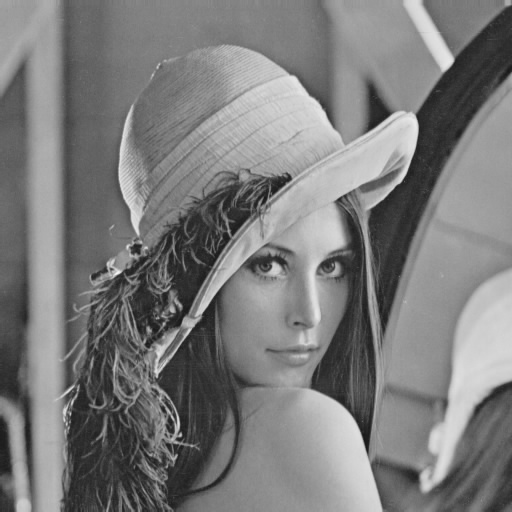

In [82]:
compress_image(image_path,quantization_matrix,0.1)

2) Medium Quality Output(q=5)

292888


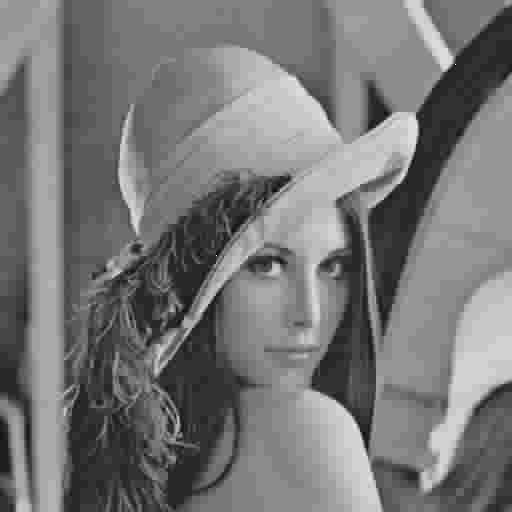

In [83]:
compress_image(image_path,quantization_matrix,5)

3)Low Quality Output (q = 15)

274993


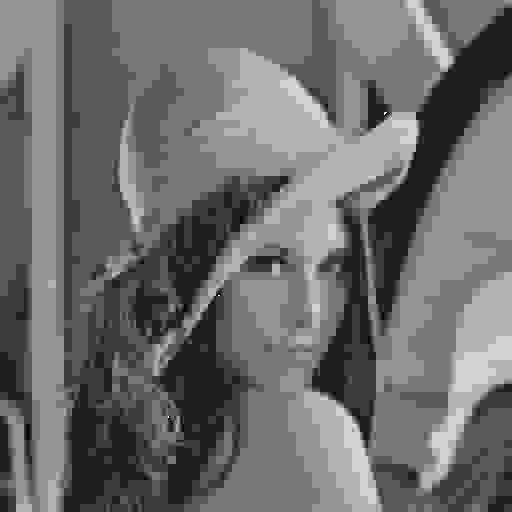

In [84]:
compress_image(image_path,quantization_matrix,15)

Original image

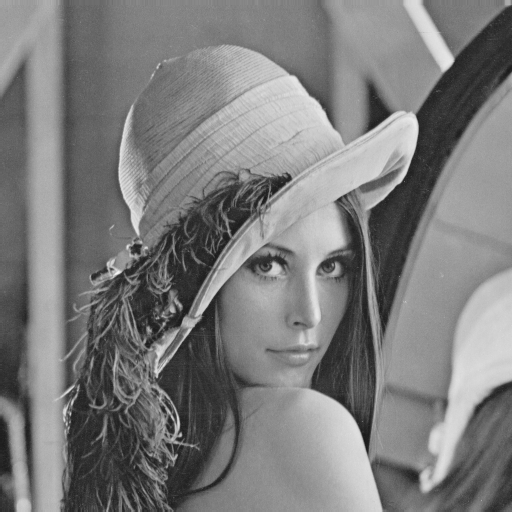

True

In [37]:
image = cv2.imread('/content/drive/MyDrive/Image and video processing/Lenna_(test_image).png')
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(grayscale_image)
cv2.imwrite('grayscale_image.jpg', grayscale_image)


###3.1.2. Adjust the compression ratio of your image encoder to meet bit rates acording to your E number.

(512, 512)
301002


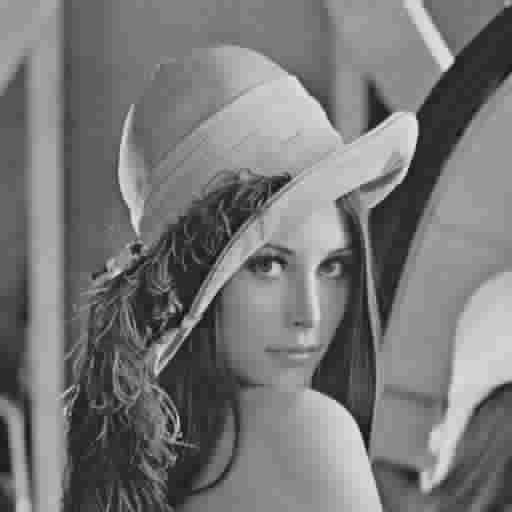

In [38]:
compress_image(image_path,quantization_matrix,3.64169)
#301 kbps

Calculating PSNR

In [40]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
from skimage.io import imread

reconstructed_image = imread('/content/drive/MyDrive/Colab Notebooks/loww.png')

original_image = grayscale_image.astype(float) / 255.0
reconstructed_image = reconstructed_image.astype(float) / 255.0

# Calculate the PSNR
psnr = peak_signal_noise_ratio(original_image, reconstructed_image)

print(f"PSNR: {psnr} dB")


PSNR: 23.81162856698904 dB


In [ ]:
original_image.shape

(512, 512, 3)